In [6]:
import torch
import numpy as np
import os, sys
import dgl
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
g = dgl.DGLGraph()
g.add_nodes(10)

src = torch.tensor(list(range(1,10)))
g.add_edges(src, 0)

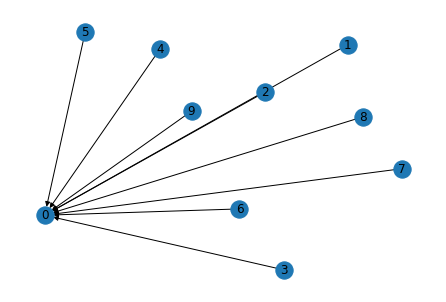

In [10]:
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

In [11]:
x = torch.randn(10, 3)
g.ndata['x']=x

#GCN example

In [15]:
# Sends a message of node feature h.
import dgl.function as fn
import torch
import torch.nn as nn
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')